In [1]:
# Necessary imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import argparse

from torch import Tensor

from qiskit import Aer, QuantumCircuit, BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.multiclass_extensions import AllPairs
from qiskit.aqua.utils.dataset_helper import get_feature_dimension

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from quantic.data import DatasetLoader
    
# Additional torch-related imports
from torch import no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim # Adam, SGD, LBFGS
from torch.nn import NLLLoss # CrossEntropyLoss, MSELoss, L1Loss, BCELoss
from qnetworks import HybridQNN_Shallow
from qnetworks import HybridQNN

#time
import timeit


In [2]:
# network args
n_classes = 2
n_qubits = 2
n_features = None
if n_features is None:
    n_features = n_qubits
network = "hybridqnn_shallow" #hybridqnn_shallow
# train args
batch_size = 1
epochs = 10
LR = 0.001
n_samples_train = 200 #128
n_samples_test = 50 #64
# plot args
n_samples_show = batch_size
# dataset args
shuffle = True
dataset = "CIFAR10" # MNIST / CIFAR10 / CIFAR100, any from pytorch
dataset_cfg = ""
specific_classes_names = ["cat","dog"] # ['0','1'] # selected (filtered) classes
print(specific_classes_names)
use_specific_classes = len(specific_classes_names)>=n_classes
# preprocessing
input_resolution = (28,28) #(28,28) # please check n_filts required on fc1/fc2 to input to qnn
resize_interpolation = transforms.functional.InterpolationMode.BILINEAR 

# Set seed for random generators
rand_seed = np.random.randint(50)
algorithm_globals.random_seed = rand_seed
manual_seed(rand_seed) # Set train shuffle seed (for reproducibility)

if not os.path.exists("plots"):
    os.mkdir("plots")

['cat', 'dog']


In [3]:


######## PREPARE DATASETS
time_start = timeit.timeit()

# Train Dataset
# -------------

if dataset_cfg:
    # Load a dataset configuration file
    dataset = DatasetLoader.load(from_cfg=dataset_cfg,framework='torchvision')
else:
    # Or instantate dataset manually
    dataset = DatasetLoader.load(dataset_type=dataset,
                                   num_classes=n_classes,
                                   specific_classes=specific_classes_names,
                                   num_samples_class_train=n_samples_train,
                                   num_samples_class_test=n_samples_test,
                                   framework='torchvision'
                                   )
print(f'Dataset partitions: {dataset.get_partitions()}')

X_train = dataset['train']
X_test = dataset['test']


# Get channels (rgb or grayscale)
if len(X_train.data.shape)>3: # 3d image (rgb+)
    n_channels = X_train.data.shape[3]
else: # 2d image (grayscale)
    n_channels = 1

if network == 'hybridqnn_shallow' or network == 'QSVM':
    # Set preprocessing transforms
    list_preprocessing = [
        transforms.Resize(input_resolution),
        transforms.ToTensor(),
    ] #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
else:
    list_preprocessing = [
        transforms.Resize(input_resolution),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
    ] #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
X_train.transform= transforms.Compose(list_preprocessing)
X_test.transform = transforms.Compose(list_preprocessing)           

# set filtered/specific class names
classes_str = ",".join(dataset.specific_classes_names)
classes2spec = {}
specific_classes = dataset.specific_classes
for idx, class_idx in enumerate(specific_classes):
    classes2spec[class_idx]=idx

classes_list = dataset.classes
n_samples = n_samples_test

Files already downloaded and verified
Files already downloaded and verified
Dataset partitions: ['train', 'test']


In [4]:
# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=shuffle)
# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=shuffle)

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Dataloaders elapsed time: {time_elapsed} s")

Dataloaders elapsed time: -2.62801768258214e-06 s


<Figure size 432x288 with 0 Axes>

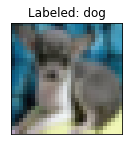

In [5]:
##### VISUALIZE LABELS
data_iter = iter(train_loader)
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    try:
        images, targets = data_iter.__next__()
    except:
        break
    plt.clf()
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for idx, image in enumerate(images):
        axes[idx].imshow(np.moveaxis(images[idx].numpy().squeeze(),0,-1))
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        class_label = classes_list[targets[idx].item()]
        axes[idx].set_title("Labeled: {}".format(class_label))
        if idx > n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_labeled_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            break
    plt.show()
    n_samples_show_alt -= 1
    

In [6]:
##### DESIGN NETWORK
time_start = timeit.timeit()



# init network
if network == "hybridqnn_shallow":
    ## predefine number of input filters to fc1 and fc2
    # examples: 13456 for (128x128x1), 59536 for (256x256x1), 256 for (28x28x1), 400 for (28x28x3) or (35x35x1) 
    if n_channels == 1:
        n_filts_fc1 = int(((((input_resolution[0]-4)/2)-4)/2)**2)*16
    else:
        #n_filts_fc1 = int(((((input_resolution[0])/2)-4)/2)**2)*16 # +7
        n_filts_fc1 = 256
    n_filts_fc2 = int(n_filts_fc1 / 4)

    # declare quantum instance
    qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
    # Define QNN
    feature_map = ZZFeatureMap(n_features)
    ansatz = RealAmplitudes(n_qubits, reps=1)
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = TwoLayerQNN(
        n_qubits, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi
    )
    print(qnn.operator)
    qnn.circuit.draw(output="mpl",filename=f"plots/qnn{n_qubits}_{n_classes}classes.png")
    #from qiskit.quantum_info import Statevector
    #from qiskit.visualization import plot_bloch_multivector
    #state = Statevector.from_instruction(qnn.circuit)
    #plot_bloch_multivector(state)
    model = HybridQNN_Shallow(n_classes = n_classes, n_qubits = n_qubits, n_channels = n_channels, n_filts_fc1 = n_filts_fc1, n_filts_fc2 = n_filts_fc2, qnn = qnn)
    print(model)

    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_func = NLLLoss()

elif network == "QSVM":
    backend = BasicAer.get_backend('qasm_simulator')

    # todo: fix this transformation for QSVM
    train_input = X_train.targets
    test_input = X_test.targets
    total_array = np.concatenate([test_input[k] for k in test_input])
    #
    feature_map = ZZFeatureMap(feature_dimension=get_feature_dimension(train_input),
                               reps=2, entanglement='linear')
    svm = QSVM(feature_map, train_input, test_input, total_array,
               multiclass_extension=AllPairs())
    quantum_instance = QuantumInstance(backend, shots=1024,
                                       seed_simulator=algorithm_globals.random_seed,
                                       seed_transpiler=algorithm_globals.random_seed)
else:
    model = HybridQNN(backbone=network,pretrained=True,n_qubits=n_qubits,n_classes=n_classes)
    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.network.parameters(), lr=LR)
    loss_func = NLLLoss()
    
time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Network init elapsed time: {time_elapsed} s")

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])
HybridQNN_Shallow(
  (conv1): Conv2d(3, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (qnn): TorchConnector()
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)
Network init elapsed time: 7.213797653093934e-05 s


Batch 0, Loss: -0.0471804141998291
Batch 1, Loss: -1.2077360153198242
Batch 2, Loss: -0.5857294797897339
Batch 3, Loss: -0.6541830897331238
Batch 4, Loss: -1.1278027296066284
Batch 5, Loss: 0.37837839126586914
Batch 6, Loss: -0.4457964301109314
Batch 7, Loss: 0.4251919984817505
Batch 8, Loss: -0.0036475062370300293
Batch 9, Loss: 0.24016046524047852
Batch 10, Loss: -1.0864797830581665
Batch 11, Loss: 0.41481471061706543
Batch 12, Loss: -0.10268402099609375
Batch 13, Loss: 0.11600828170776367
Batch 14, Loss: 0.3911564350128174
Batch 15, Loss: -1.231160044670105
Batch 16, Loss: -1.4112062454223633
Batch 17, Loss: -0.8632773756980896
Batch 18, Loss: -0.3690594434738159
Batch 19, Loss: -1.083810806274414
Batch 20, Loss: -1.3164782524108887
Batch 21, Loss: -0.8451248407363892
Batch 22, Loss: -0.1272820234298706
Batch 23, Loss: 0.41173577308654785
Batch 24, Loss: -0.030517637729644775
Batch 25, Loss: -1.250834584236145
Batch 26, Loss: -0.9966474771499634
Batch 27, Loss: -0.8151662945747375
B

Batch 224, Loss: 0.016841530799865723
Batch 225, Loss: -0.2122408151626587
Batch 226, Loss: -0.9246516227722168
Batch 227, Loss: -0.5686277151107788
Batch 228, Loss: -0.9207239747047424
Batch 229, Loss: -0.2774442732334137
Batch 230, Loss: -1.3061354160308838
Batch 231, Loss: -0.11678427457809448
Batch 232, Loss: -0.039724111557006836
Batch 233, Loss: -0.5353087782859802
Batch 234, Loss: -0.0668635368347168
Batch 235, Loss: -0.5992588996887207
Batch 236, Loss: -0.41155123710632324
Batch 237, Loss: -0.19423454999923706
Batch 238, Loss: -0.08426588773727417
Batch 239, Loss: -1.196860671043396
Batch 240, Loss: -0.198630690574646
Batch 241, Loss: -0.3184165060520172
Batch 242, Loss: -0.22734075784683228
Batch 243, Loss: -0.14355987310409546
Batch 244, Loss: -0.8939827680587769
Batch 245, Loss: -0.8310934901237488
Batch 246, Loss: -0.3099334239959717
Batch 247, Loss: -0.18720215559005737
Batch 248, Loss: -0.5799584984779358
Batch 249, Loss: 0.17072820663452148
Batch 250, Loss: -0.3899702727

Batch 46, Loss: -0.5908381342887878
Batch 47, Loss: -1.170830249786377
Batch 48, Loss: -0.8263470530509949
Batch 49, Loss: -0.1934497356414795
Batch 50, Loss: -0.16382712125778198
Batch 51, Loss: -0.18079215288162231
Batch 52, Loss: -0.014569461345672607
Batch 53, Loss: -0.14512121677398682
Batch 54, Loss: 0.004820764064788818
Batch 55, Loss: -0.3451251685619354
Batch 56, Loss: -0.8019998669624329
Batch 57, Loss: -0.6063450574874878
Batch 58, Loss: -0.06476438045501709
Batch 59, Loss: -0.218927264213562
Batch 60, Loss: -0.12077975273132324
Batch 61, Loss: -0.5698192119598389
Batch 62, Loss: 0.08205556869506836
Batch 63, Loss: 0.0962139368057251
Batch 64, Loss: -0.626164436340332
Batch 65, Loss: 0.03434133529663086
Batch 66, Loss: -0.979503870010376
Batch 67, Loss: -0.37785279750823975
Batch 68, Loss: -0.8647335171699524
Batch 69, Loss: -1.1830041408538818
Batch 70, Loss: -0.9451022744178772
Batch 71, Loss: -0.5292971730232239
Batch 72, Loss: -0.8708144426345825
Batch 73, Loss: -0.37587

Batch 269, Loss: -0.9124452471733093
Batch 270, Loss: -0.8983371257781982
Batch 271, Loss: -0.6947662830352783
Batch 272, Loss: -0.8588568568229675
Batch 273, Loss: -1.3311102390289307
Batch 274, Loss: -1.2274651527404785
Batch 275, Loss: -0.7222590446472168
Batch 276, Loss: -0.4188627004623413
Batch 277, Loss: -0.6051852703094482
Batch 278, Loss: -0.5857970714569092
Batch 279, Loss: -0.5089774131774902
Batch 280, Loss: -0.016912341117858887
Batch 281, Loss: -0.6361171007156372
Batch 282, Loss: -0.7989070415496826
Batch 283, Loss: -0.46718886494636536
Batch 284, Loss: -0.07913678884506226
Batch 285, Loss: -0.45641231536865234
Batch 286, Loss: -0.41191965341567993
Batch 287, Loss: -0.8676363825798035
Batch 288, Loss: -0.8596714735031128
Batch 289, Loss: 0.07851135730743408
Batch 290, Loss: -0.09454613924026489
Batch 291, Loss: -0.9040815830230713
Batch 292, Loss: 0.260967493057251
Batch 293, Loss: -0.5490272045135498
Batch 294, Loss: -0.9711819291114807
Batch 295, Loss: -1.0741522312164

Batch 92, Loss: -0.44971930980682373
Batch 93, Loss: -0.2703913450241089
Batch 94, Loss: -0.5639961957931519
Batch 95, Loss: -0.15262234210968018
Batch 96, Loss: -0.9116050601005554
Batch 97, Loss: -0.9587178826332092
Batch 98, Loss: -1.0800652503967285
Batch 99, Loss: 0.1760721206665039
Batch 100, Loss: 0.06240344047546387
Batch 101, Loss: -0.3220975399017334
Batch 102, Loss: -0.5447179675102234
Batch 103, Loss: -0.5264976024627686
Batch 104, Loss: 0.04520249366760254
Batch 105, Loss: -0.7648378014564514
Batch 106, Loss: -0.33370816707611084
Batch 107, Loss: -0.2682434320449829
Batch 108, Loss: -0.11754071712493896
Batch 109, Loss: -1.435943603515625
Batch 110, Loss: -0.1605655550956726
Batch 111, Loss: 0.19624745845794678
Batch 112, Loss: -0.5088059902191162
Batch 113, Loss: -0.037320077419281006
Batch 114, Loss: -0.3551030158996582
Batch 115, Loss: -1.2787307500839233
Batch 116, Loss: -0.6502885222434998
Batch 117, Loss: -0.4352636933326721
Batch 118, Loss: -0.41386088728904724
Batc

Batch 313, Loss: -0.5803765654563904
Batch 314, Loss: -0.7418956756591797
Batch 315, Loss: -0.24922895431518555
Batch 316, Loss: -0.9252843260765076
Batch 317, Loss: -0.16447323560714722
Batch 318, Loss: -0.36595776677131653
Batch 319, Loss: 0.22586047649383545
Batch 320, Loss: -0.6559416055679321
Batch 321, Loss: 0.15973472595214844
Batch 322, Loss: -0.7633379101753235
Batch 323, Loss: -0.7855792045593262
Batch 324, Loss: -0.6518457531929016
Batch 325, Loss: -0.38543349504470825
Batch 326, Loss: 0.03534245491027832
Batch 327, Loss: 0.08720481395721436
Batch 328, Loss: -0.7544101476669312
Batch 329, Loss: -0.8840689063072205
Batch 330, Loss: 0.05688345432281494
Batch 331, Loss: -0.32212284207344055
Batch 332, Loss: -0.03156173229217529
Batch 333, Loss: -0.3342764377593994
Batch 334, Loss: -1.1734857559204102
Batch 335, Loss: -0.16308486461639404
Batch 336, Loss: 0.3441956043243408
Batch 337, Loss: -0.729875922203064
Batch 338, Loss: -0.8970298767089844
Batch 339, Loss: -0.6581058502197

Batch 136, Loss: -0.5230062007904053
Batch 137, Loss: -0.617941677570343
Batch 138, Loss: -0.18757927417755127
Batch 139, Loss: 0.29384827613830566
Batch 140, Loss: -0.848432183265686
Batch 141, Loss: -0.37471580505371094
Batch 142, Loss: 0.2981492280960083
Batch 143, Loss: -0.2463971972465515
Batch 144, Loss: 0.2863210439682007
Batch 145, Loss: -1.0501763820648193
Batch 146, Loss: -0.5554355382919312
Batch 147, Loss: -0.5991805791854858
Batch 148, Loss: -0.30654817819595337
Batch 149, Loss: 0.11923348903656006
Batch 150, Loss: -1.126651644706726
Batch 151, Loss: -0.6789324879646301
Batch 152, Loss: -0.0008236169815063477
Batch 153, Loss: 0.010729670524597168
Batch 154, Loss: -0.7354800701141357
Batch 155, Loss: -0.8836468458175659
Batch 156, Loss: -0.9863393902778625
Batch 157, Loss: -1.0102514028549194
Batch 158, Loss: -0.5242273807525635
Batch 159, Loss: -0.3177862763404846
Batch 160, Loss: -0.8092264533042908
Batch 161, Loss: -0.980665922164917
Batch 162, Loss: -1.1751452684402466


Batch 357, Loss: -0.802819013595581
Batch 358, Loss: -0.34114277362823486
Batch 359, Loss: -0.05256545543670654
Batch 360, Loss: -0.9751788377761841
Batch 361, Loss: -0.3463855981826782
Batch 362, Loss: -0.9661628007888794
Batch 363, Loss: -0.40081146359443665
Batch 364, Loss: -0.5326160192489624
Batch 365, Loss: -0.2671511173248291
Batch 366, Loss: 0.267122745513916
Batch 367, Loss: -0.4204327464103699
Batch 368, Loss: -0.9885850548744202
Batch 369, Loss: -0.6730139255523682
Batch 370, Loss: 0.3284287452697754
Batch 371, Loss: -0.32849758863449097
Batch 372, Loss: -1.4676933288574219
Batch 373, Loss: -0.6893483400344849
Batch 374, Loss: -0.256200909614563
Batch 375, Loss: -0.8852499127388
Batch 376, Loss: -0.5994067192077637
Batch 377, Loss: -0.3606640100479126
Batch 378, Loss: -0.6834394335746765
Batch 379, Loss: -0.47974711656570435
Batch 380, Loss: -0.5308228731155396
Batch 381, Loss: -0.08902531862258911
Batch 382, Loss: -0.8178085684776306
Batch 383, Loss: -0.11718976497650146
Ba

Batch 180, Loss: -0.5627949237823486
Batch 181, Loss: -0.38472068309783936
Batch 182, Loss: -0.2596637010574341
Batch 183, Loss: 0.14205074310302734
Batch 184, Loss: -0.22373569011688232
Batch 185, Loss: -1.0890637636184692
Batch 186, Loss: -0.3064596951007843
Batch 187, Loss: -0.2887641489505768
Batch 188, Loss: -0.1542721390724182
Batch 189, Loss: -0.23644894361495972
Batch 190, Loss: -0.6802207231521606
Batch 191, Loss: -0.5290476083755493
Batch 192, Loss: -0.07746309041976929
Batch 193, Loss: 0.23510980606079102
Batch 194, Loss: -1.1451616287231445
Batch 195, Loss: -1.0194827318191528
Batch 196, Loss: -0.18463516235351562
Batch 197, Loss: -0.9060295224189758
Batch 198, Loss: -0.6016595959663391
Batch 199, Loss: -0.5494098663330078
Batch 200, Loss: -0.6120449304580688
Batch 201, Loss: -0.20941942930221558
Batch 202, Loss: -0.8459445238113403
Batch 203, Loss: -0.609959602355957
Batch 204, Loss: 0.03943312168121338
Batch 205, Loss: -0.4424303472042084
Batch 206, Loss: -1.0840855836868

Batch 1, Loss: -0.7832902669906616
Batch 2, Loss: -0.6353173851966858
Batch 3, Loss: -0.219832181930542
Batch 4, Loss: -0.5375924110412598
Batch 5, Loss: 0.12272334098815918
Batch 6, Loss: -0.1569974422454834
Batch 7, Loss: -0.7514232397079468
Batch 8, Loss: -0.3014187216758728
Batch 9, Loss: -0.23346972465515137
Batch 10, Loss: -0.4401896595954895
Batch 11, Loss: -0.7392719984054565
Batch 12, Loss: 0.004989266395568848
Batch 13, Loss: -0.09596741199493408
Batch 14, Loss: -1.0396976470947266
Batch 15, Loss: -0.9890342354774475
Batch 16, Loss: -0.7202389240264893
Batch 17, Loss: -0.6342625617980957
Batch 18, Loss: -1.116074800491333
Batch 19, Loss: -0.4347797930240631
Batch 20, Loss: -0.8800151348114014
Batch 21, Loss: -0.7357051968574524
Batch 22, Loss: -0.734886646270752
Batch 23, Loss: -0.70721834897995
Batch 24, Loss: -0.24902021884918213
Batch 25, Loss: -0.5369084477424622
Batch 26, Loss: -0.09417879581451416
Batch 27, Loss: -0.22363340854644775
Batch 28, Loss: -0.6090275049209595


Batch 225, Loss: -0.48962610960006714
Batch 226, Loss: -1.162458062171936
Batch 227, Loss: -0.5473237037658691
Batch 228, Loss: -0.5635169744491577
Batch 229, Loss: -0.9410465955734253
Batch 230, Loss: -0.46866345405578613
Batch 231, Loss: -0.26422810554504395
Batch 232, Loss: -0.8776795864105225
Batch 233, Loss: -1.0428804159164429
Batch 234, Loss: -0.3662940263748169
Batch 235, Loss: -0.41736888885498047
Batch 236, Loss: 0.018929004669189453
Batch 237, Loss: -0.1830543875694275
Batch 238, Loss: -0.6731042265892029
Batch 239, Loss: -0.800768256187439
Batch 240, Loss: 0.07209551334381104
Batch 241, Loss: 0.026400327682495117
Batch 242, Loss: -0.6243735551834106
Batch 243, Loss: -0.608039140701294
Batch 244, Loss: -0.6432470083236694
Batch 245, Loss: -0.11289447546005249
Batch 246, Loss: -0.501750648021698
Batch 247, Loss: 0.045415520668029785
Batch 248, Loss: -0.450764536857605
Batch 249, Loss: -0.5779764652252197
Batch 250, Loss: -0.5834662914276123
Batch 251, Loss: -0.591456294059753

Batch 47, Loss: 0.000674903392791748
Batch 48, Loss: -0.31249886751174927
Batch 49, Loss: -0.06986922025680542
Batch 50, Loss: -0.42862480878829956
Batch 51, Loss: -0.9497308731079102
Batch 52, Loss: -0.6874411106109619
Batch 53, Loss: -0.26758062839508057
Batch 54, Loss: -0.987114667892456
Batch 55, Loss: -1.095263957977295
Batch 56, Loss: -0.11610865592956543
Batch 57, Loss: -0.5635011196136475
Batch 58, Loss: -0.9284473657608032
Batch 59, Loss: -0.7711907029151917
Batch 60, Loss: -0.44882792234420776
Batch 61, Loss: -0.47213149070739746
Batch 62, Loss: 0.3130086660385132
Batch 63, Loss: 0.01437997817993164
Batch 64, Loss: -0.2158294916152954
Batch 65, Loss: -0.24059617519378662
Batch 66, Loss: -0.3360985219478607
Batch 67, Loss: -0.6463869214057922
Batch 68, Loss: -0.9558646082878113
Batch 69, Loss: 0.1601734161376953
Batch 70, Loss: -0.08958959579467773
Batch 71, Loss: 0.15489602088928223
Batch 72, Loss: -0.4650716781616211
Batch 73, Loss: -0.3262271285057068
Batch 74, Loss: -0.479

Batch 270, Loss: -0.6253806948661804
Batch 271, Loss: -0.3677899241447449
Batch 272, Loss: 0.3797271251678467
Batch 273, Loss: -1.2884275913238525
Batch 274, Loss: 0.4014458656311035
Batch 275, Loss: 0.27483344078063965
Batch 276, Loss: -0.8514484763145447
Batch 277, Loss: -0.4591240882873535
Batch 278, Loss: -0.3367966115474701
Batch 279, Loss: -0.1750500202178955
Batch 280, Loss: -0.24513769149780273
Batch 281, Loss: -0.37654340267181396
Batch 282, Loss: -0.5960327386856079
Batch 283, Loss: -0.8232004046440125
Batch 284, Loss: 0.031022310256958008
Batch 285, Loss: -0.36332112550735474
Batch 286, Loss: 0.30631983280181885
Batch 287, Loss: -0.11865711212158203
Batch 288, Loss: -0.8840785026550293
Batch 289, Loss: -0.16549444198608398
Batch 290, Loss: 0.089272141456604
Batch 291, Loss: -1.1502269506454468
Batch 292, Loss: -0.20038896799087524
Batch 293, Loss: -0.5051663517951965
Batch 294, Loss: -0.8108303546905518
Batch 295, Loss: -0.6722986102104187
Batch 296, Loss: -0.701061308383941

Batch 93, Loss: -0.506847620010376
Batch 94, Loss: -0.23798155784606934
Batch 95, Loss: -0.7974259853363037
Batch 96, Loss: 0.17964410781860352
Batch 97, Loss: -0.3636305332183838
Batch 98, Loss: -0.2907767593860626
Batch 99, Loss: -0.6882563829421997
Batch 100, Loss: -0.14350074529647827
Batch 101, Loss: -0.0404740571975708
Batch 102, Loss: -0.38219302892684937
Batch 103, Loss: -0.24523979425430298
Batch 104, Loss: -0.9052023887634277
Batch 105, Loss: -0.7165948152542114
Batch 106, Loss: -0.299083948135376
Batch 107, Loss: -0.32308945059776306
Batch 108, Loss: -0.24721509218215942
Batch 109, Loss: 0.1492081880569458
Batch 110, Loss: -0.02273029088973999
Batch 111, Loss: -0.7175132632255554
Batch 112, Loss: -0.4442329406738281
Batch 113, Loss: -0.5619258880615234
Batch 114, Loss: -1.2344295978546143
Batch 115, Loss: -1.351054310798645
Batch 116, Loss: -0.16265666484832764
Batch 117, Loss: -0.6970184445381165
Batch 118, Loss: -0.9082903265953064
Batch 119, Loss: -0.3872988820075989
Batc

Batch 314, Loss: -0.8187737464904785
Batch 315, Loss: -0.5589514970779419
Batch 316, Loss: -0.4356577396392822
Batch 317, Loss: -0.11302101612091064
Batch 318, Loss: -0.3189268410205841
Batch 319, Loss: -0.41210055351257324
Batch 320, Loss: -0.6619864702224731
Batch 321, Loss: -0.4278406500816345
Batch 322, Loss: -1.2665138244628906
Batch 323, Loss: -0.34267228841781616
Batch 324, Loss: -0.32840123772621155
Batch 325, Loss: -0.8433419466018677
Batch 326, Loss: -0.6641770601272583
Batch 327, Loss: -0.4268907904624939
Batch 328, Loss: -0.5983422994613647
Batch 329, Loss: -0.7373669147491455
Batch 330, Loss: -1.1907968521118164
Batch 331, Loss: -0.4912377595901489
Batch 332, Loss: -0.07780903577804565
Batch 333, Loss: -0.4855378270149231
Batch 334, Loss: -1.205087423324585
Batch 335, Loss: -0.33505886793136597
Batch 336, Loss: -0.34437811374664307
Batch 337, Loss: -0.3222377896308899
Batch 338, Loss: -0.5455036163330078
Batch 339, Loss: -1.2177281379699707
Batch 340, Loss: -0.209432125091

Batch 137, Loss: -0.5779246091842651
Batch 138, Loss: -0.6642156839370728
Batch 139, Loss: -0.2136385440826416
Batch 140, Loss: -0.7957953810691833
Batch 141, Loss: 0.1826632022857666
Batch 142, Loss: -0.6672546863555908
Batch 143, Loss: -0.3549420237541199
Batch 144, Loss: -0.7753753066062927
Batch 145, Loss: -0.5508596897125244
Batch 146, Loss: -0.4873734712600708
Batch 147, Loss: -1.333399772644043
Batch 148, Loss: 0.08077263832092285
Batch 149, Loss: -0.9566566944122314
Batch 150, Loss: 0.05910658836364746
Batch 151, Loss: -0.08519905805587769
Batch 152, Loss: -0.24774497747421265
Batch 153, Loss: -0.7203917503356934
Batch 154, Loss: -0.20665597915649414
Batch 155, Loss: -0.5075389742851257
Batch 156, Loss: -0.26023662090301514
Batch 157, Loss: -0.7752406001091003
Batch 158, Loss: -0.7395074367523193
Batch 159, Loss: 0.1894223690032959
Batch 160, Loss: -1.0114593505859375
Batch 161, Loss: -0.161288321018219
Batch 162, Loss: -0.45460695028305054
Batch 163, Loss: -0.05035156011581421

Batch 358, Loss: 0.030514955520629883
Batch 359, Loss: -0.4819899797439575
Batch 360, Loss: -0.7431691884994507
Batch 361, Loss: 0.14418697357177734
Batch 362, Loss: -0.35655808448791504
Batch 363, Loss: -0.44312310218811035
Batch 364, Loss: -0.6762717366218567
Batch 365, Loss: -1.3969616889953613
Batch 366, Loss: -0.09285134077072144
Batch 367, Loss: -0.5472038388252258
Batch 368, Loss: -0.3662158250808716
Batch 369, Loss: -0.24662071466445923
Batch 370, Loss: -0.8111624717712402
Batch 371, Loss: -0.6680872440338135
Batch 372, Loss: -1.1901302337646484
Batch 373, Loss: -0.25159788131713867
Batch 374, Loss: -0.11684924364089966
Batch 375, Loss: -0.3900182247161865
Batch 376, Loss: -0.5652875900268555
Batch 377, Loss: -0.6034820079803467
Batch 378, Loss: -0.7559584379196167
Batch 379, Loss: -0.8678379654884338
Batch 380, Loss: -0.46319031715393066
Batch 381, Loss: -0.6046678423881531
Batch 382, Loss: -0.9018915891647339
Batch 383, Loss: -0.11589193344116211
Batch 384, Loss: -0.851282775

Batch 181, Loss: -0.78113853931427
Batch 182, Loss: -0.8382176756858826
Batch 183, Loss: -0.4297272861003876
Batch 184, Loss: -0.7377245426177979
Batch 185, Loss: -0.5472952723503113
Batch 186, Loss: -0.7310705184936523
Batch 187, Loss: -0.8972862958908081
Batch 188, Loss: -0.14547419548034668
Batch 189, Loss: -0.6140860915184021
Batch 190, Loss: -1.4418995380401611
Batch 191, Loss: -0.6211787462234497
Batch 192, Loss: -0.5785268545150757
Batch 193, Loss: -0.8656067252159119
Batch 194, Loss: -0.5912436842918396
Batch 195, Loss: -0.2824699580669403
Batch 196, Loss: -0.6813477277755737
Batch 197, Loss: 0.02273392677307129
Batch 198, Loss: -0.6425901651382446
Batch 199, Loss: -0.48676466941833496
Batch 200, Loss: -0.25502508878707886
Batch 201, Loss: -1.2068603038787842
Batch 202, Loss: -0.5216131806373596
Batch 203, Loss: -0.3066217601299286
Batch 204, Loss: 0.2721381187438965
Batch 205, Loss: -0.01753091812133789
Batch 206, Loss: -0.11270076036453247
Batch 207, Loss: -0.8606237769126892

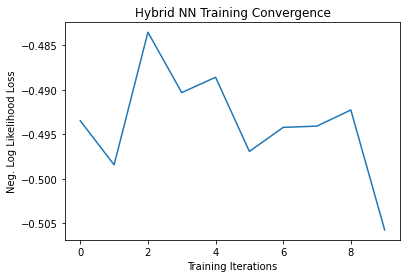

Training time: -0.0005447650328278542 s


In [7]:
################# TRAIN
# Start training
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.train()  # Set model to training mode
    if network == "hybridqnn_shallow":
        model.train()  # Set model to training mode
        
    loss_list = []  # Store loss history
    for epoch in range(epochs):
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad(set_to_none=True)  # Initialize gradient
            output = model(data)  # Forward pass
            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            loss = loss_func(output, target)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights
            total_loss.append(loss.item())  # Store loss
            print(f"Batch {batch_idx}, Loss: {total_loss[-1]}")
        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

    # Plot loss convergence
    plt.clf()
    plt.plot(loss_list)
    plt.title("Hybrid NN Training Convergence")
    plt.xlabel("Training Iterations")
    plt.ylabel("Neg. Log Likelihood Loss")
    #plt.savefig(f"plots/{dataset}_classification{classes_str}_hybridqnn_q{n_qubits}_{n_samples}samples_lr{LR}_bsize{batch_size}.png")
    plt.show()
    
elif network == "QSVM":
    result = svm.run(quantum_instance)
    for k,v in result.items():
        print(f'{k} : {v}')

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Training time: {time_elapsed} s")

In [ ]:
######## TEST
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.eval()  # Set model to eval mode
    if network == "hybridqnn_shallow":
        model.eval()  # Set model to eval mode
    with no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)
            pred = output.argmax(dim=1, keepdim=True)

            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target)
            total_loss.append(loss.item())

        print(
            "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
                sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
            )
        )

    time_end = timeit.timeit()
    time_elapsed = time_end - time_start
    print(f"Test time: {time_elapsed} s")
    
    


In [ ]:
# Plot predicted labels
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    plt.clf()
    count = 0
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for batch_idx, (data, target) in enumerate(test_loader):    
        if count == n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_pred_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            plt.show()
            break
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        for sample_idx in range(batch_size):
            try:
                class_label = classes_list[specific_classes[pred[sample_idx].item()]]
            except:
                class_label = classes_list[specific_classes[pred[sample_idx].item()-1]]
            axes[count].imshow(np.moveaxis(data[sample_idx].numpy().squeeze(),0,-1))
            axes[count].set_xticks([])
            axes[count].set_yticks([])
            axes[count].set_title(class_label)
            count += 1
    n_samples_show_alt -= 1

### 